# Import libraries

In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from keras.utils import to_categorical, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
# Define ShakeShake function as custom object
class ShakeShake(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ShakeShake, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        if training:
            alpha = K.random_uniform(shape=[tf.shape(inputs[0])[0], 1, 1, 1])
            beta = K.random_uniform(shape=[tf.shape(inputs[0])[0], 1, 1, 1])
        else:
            alpha = 0.5
            beta = 0.5
        return inputs[0] * alpha + inputs[1] * beta

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
    def get_config(self):
        config = super(ShakeShake, self).get_config()
        return config

In [3]:
def setSeed(seed=404):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# Define dataset paths
k49Path = os.getcwd() + "\\datasets\\K49\\"

trainData = np.load(k49Path + 'k49-train-imgs.npz')['arr_0']
trainLabel = np.load(k49Path + 'k49-train-labels.npz')['arr_0']
labelIndices = pd.read_csv(k49Path + 'new_k49_classmap.csv')

# Load models

In [5]:
firstPath = "models/CustomCNN1.h5"
secPath = "models/CustomCNN2.h5"
transferPath = "models/TransferLearningModel.h5"

In [6]:
cnn1 = load_model(firstPath, custom_objects={'ShakeShake': ShakeShake})
cnn2 = load_model(secPath, custom_objects={'ShakeShake': ShakeShake})
transferCNN = load_model(transferPath, custom_objects={'ShakeShake': ShakeShake})

# Ensemble model prediction

In [7]:
# Prepare data for transfer model

def reshapeImage(image):
    img = array_to_img(image, scale = False) # return PIL Image
    img = img.resize((64, 64)) # resize the image
    img = img.convert(mode = 'RGB') # converts to 3 channels
    imgArray = img_to_array(img) # convert back to array
    return imgArray.astype(np.float64)

reshapedTrain = (trainData.reshape(-1,28,28,1))

resizedTrain = np.array([reshapeImage(img) for img in reshapedTrain])

In [8]:
import sys

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  resizedTrain: 21.3 GiB
                     trainData: 173.7 MiB
                    trainLabel: 227.0 KiB
                  labelIndices: 10.4 KiB
                    ShakeShake:  2.0 KiB
            ImageDataGenerator:  1.0 KiB
                 EarlyStopping:  1.0 KiB
                           _i2:  740.0 B
                           _i1:  589.0 B
                           _i8:  514.0 B


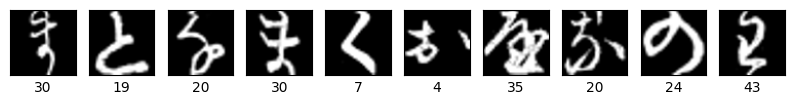

In [9]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(resizedTrain[i] / 255, cmap = 'gray')
    plt.xlabel(trainLabel[i])
plt.show()

In [10]:
# Create the parameters for the training
batchSize = 32
toUseTrainTransfer = resizedTrain
toUseTrainLabel = to_categorical(trainLabel, 49)

trainGen = ImageDataGenerator(rescale = 1./255,
                              validation_split = 0.2)

trainGenTransfer = trainGen.flow(
    toUseTrainTransfer,
    toUseTrainLabel,
    batch_size = batchSize,
    subset = 'training')

validGenTransfer = trainGen.flow(
    toUseTrainTransfer,
    toUseTrainLabel,
    batch_size = batchSize,
    subset = 'validation')

In [11]:
callback = EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 5, restore_best_weights = True)

# Set training seed to be same as other models
setSeed()

In [12]:
# Fit the transfer model to K49 dataset
finalTrained = transferCNN.fit(trainGenTransfer, epochs = 100, callbacks = callback, 
                               steps_per_epoch = len(trainGenTransfer) // batchSize, 
                               validation_data = validGenTransfer, validation_steps = len(validGenTransfer) // batchSize)

Epoch 1/100
181/181 [==============================] - 28s 79ms/step - loss: 3.6649 - accuracy: 0.2013 - val_loss: 2.5323 - val_accuracy: 0.4229
Epoch 2/100
181/181 [==============================] - 12s 66ms/step - loss: 1.9228 - accuracy: 0.5107 - val_loss: 1.4109 - val_accuracy: 0.6896
Epoch 3/100
181/181 [==============================] - 12s 66ms/step - loss: 1.3526 - accuracy: 0.6587 - val_loss: 1.0077 - val_accuracy: 0.7604
Epoch 4/100
181/181 [==============================] - 12s 64ms/step - loss: 1.0834 - accuracy: 0.7288 - val_loss: 0.8132 - val_accuracy: 0.8056
Epoch 5/100
181/181 [==============================] - 12s 67ms/step - loss: 0.8922 - accuracy: 0.7868 - val_loss: 0.7378 - val_accuracy: 0.8167
Epoch 6/100
181/181 [==============================] - 11s 63ms/step - loss: 0.8313 - accuracy: 0.8099 - val_loss: 0.6097 - val_accuracy: 0.8444
Epoch 7/100
181/181 [==============================] - 12s 66ms/step - loss: 0.7471 - accuracy: 0.8201 - val_loss: 0.5215 - val_ac

In [13]:
print('Highest validation accuracy: ', max(finalTrained.history['val_accuracy']))

# Save the final model
transferCNN.save('models/FinalTransferLearningModel.h5')

Highest validation accuracy:  0.956250011920929


In [14]:
X_train, X_val, y_train, y_val = train_test_split(trainData, trainLabel, test_size=0.2, random_state=404)

del trainData, trainLabel, trainGenTransfer, validGenTransfer

In [15]:
reshapedVal = (X_val.reshape(-1,28,28,1))
resizedVal = np.array([reshapeImage(img) / 255 for img in reshapedVal])

testData = X_val / 255
reshapedVal = (testData.reshape(-1,28,28,1))

In [16]:
firstPreds = cnn1.predict(reshapedVal)
secPreds = cnn2.predict(reshapedVal)
transferPreds = transferCNN.predict(resizedVal)

1453/1453 [==============================] - 46s 30ms/step


In [17]:
ensemblePreds = np.stack([firstPreds, secPreds, transferPreds])
sumPreds = np.sum(ensemblePreds, axis=0)
finalPreds = np.argmax(sumPreds, axis=-1)

# True labels
true_labels = y_val

# Calculate accuracy based on suggested calculation formula
accuracy = np.mean(finalPreds == true_labels)
print(f'Ensemble model accuracy: {accuracy * 100:.2f}%')

Ensemble model accuracy: 97.74%


## Accuracy visualisation

In [19]:
# Get the confusion matrix for ensemble model
ensembleConf = confusion_matrix(true_labels, finalPreds, labels = labelIndices['index'])

In [21]:
# Print out the confusion matrix using seaborn heatmap
dfConfusionEnsemble = pd.DataFrame(ensembleConf, index = labelIndices['char'], columns = labelIndices['char'])

<Figure size 2000x1800 with 0 Axes>

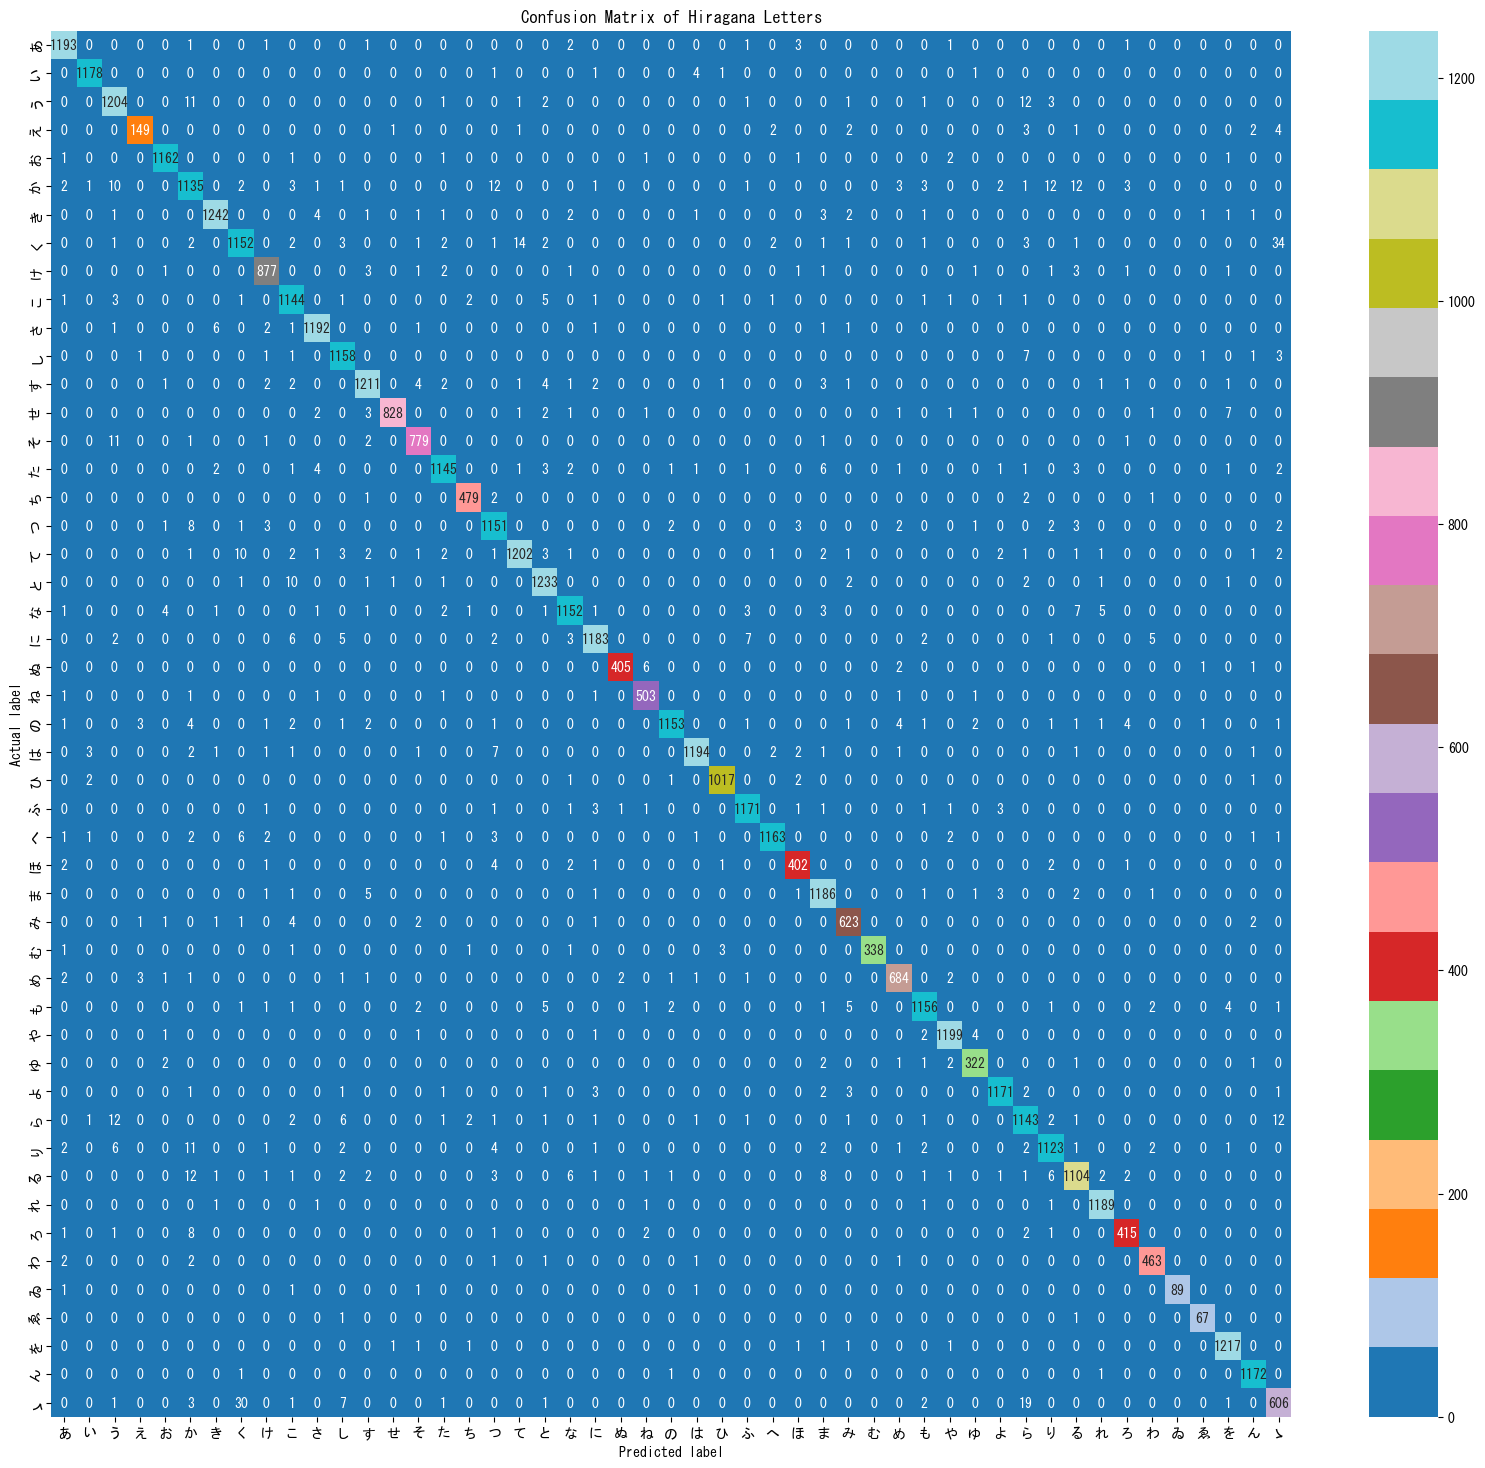

In [23]:
# Plot confusion matrices for all models
plt.rcParams['font.family'] = 'MS Gothic'
plt.figure(figsize=(20,18))

plt.figure(figsize=(20,18))
sns.heatmap(dfConfusionEnsemble, annot=True, fmt='d', cmap = 'tab20')
plt.title("Confusion Matrix of Hiragana Letters")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()